In [5]:
import pandas as pd

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%pylab inline

In [2]:
data_path = '/home/khrylchenko-ky/project/data/novgorod_transactions_2018-m3-8_lemm_new.csv'

dtypes = {
'c_kl_kt_2_inn': str,
'c_kl_dt_2_inn': str
}

names = {
    'c_kl_kt_2_inn': 'seller',
    'c_kl_dt_2_inn': 'buyer',
    'post_ngramm_lemm': 'text',
}

usecols = ['c_kl_kt_2_inn', 'c_kl_dt_2_inn', 'post_ngramm_lem']

In [3]:
data = pd.read_csv(data_path, sep=';', dtype=dtypes, usecols=usecols).rename(columns=names)

/opt/cloudera/parcels/PYENV.ZNO0059623792/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
firms_path = '/home/khrylchenko-ky/project/data/novgorod_firms_new.csv'

names = {
    'ul_inn': 'inn',
    'okved_lvl_0': 'okved0',
    'okved_lvl_1': 'okved1',
    'all_okved_lvl_2': 'all_okved',
    'ul_okato_reg': 'region',
    'c_crm_segment': 'segment'
}

usecols = ['ul_inn', 'okved', 'okved_lvl_0', 'okved_lvl_1', 'all_okved_lvl_2', 'ul_okato_reg', 'c_crm_segment']

dtypes = {
    'ul_inn': str,
    'ul_okato_reg': str,
    'ul_kpp_reg': str
}

firms = pd.read_csv(firms_path, sep=';', dtype=dtypes, usecols=usecols).rename(columns=names)

In [7]:
data['okved0'] = data['seller'].map(firms.set_index('inn')['okved0'])

In [8]:
data['n_prod'] = data['post_ngramm_lem'].fillna('').str.split().map(len)

In [10]:
data['post_ngramm_lem'].fillna('', inplace=True)

/opt/cloudera/parcels/PYENV.ZNO0059623792/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


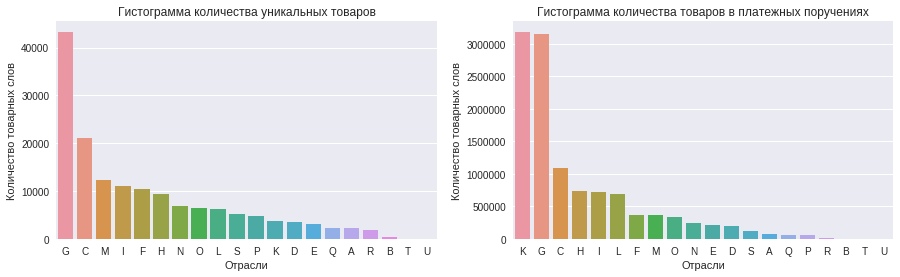

In [14]:
tmp = data.groupby('okved0', sort=False)['post_ngramm_lem'].apply(' '.join)

unique_products = tmp.apply(lambda x: len(set(x.split())))
products = tmp.apply(lambda x: len(x.split()))

products.sort_values(ascending=False, inplace=True)
unique_products.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.title('Гистограмма количества уникальных товаров')
sns.barplot(x=unique_products.index, y=unique_products.values)
plt.xlabel('Отрасли')
plt.ylabel('Количество товарных слов')

plt.subplot(1, 2, 2)
plt.title('Гистограмма количества товаров в платежных поручениях')
sns.barplot(x=products.index, y=products.values)
plt.xlabel('Отрасли')
plt.ylabel('Количество товарных слов')

/opt/cloudera/parcels/PYENV.ZNO0059623792/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


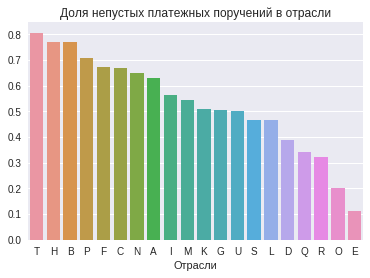

In [16]:
data['has_products'] = data['n_prod'] > 0
tmp = data.groupby('okved0', sort=False)['has_products'].mean()
tmp.sort_values(ascending=False, inplace=True)

plt.title('Доля непустых платежных поручений в отрасли')
sns.barplot(x=tmp.index, y=tmp.values)
plt.xlabel('Отрасли')

In [17]:
fields = data['okved0'].dropna().unique()

In [42]:
def plot_words(field, k=25, save=False):
    corpus = data.loc[data['okved0'] == field, 'post_ngramm_lem']
    cnt = Counter()
    for doc in corpus:
        cnt.update(doc.split())

    words, freqs = list(zip(*cnt.most_common()))
    words = list(words)
    freqs = list(freqs)

    plt.figure(figsize=(24, 5))
    plt.plot(freqs[:k])
    plt.xticks(range(k), words[:k], rotation=30)
    plt.title('Наиболее популярные товарные слова в отрасли {}'.format(field))
    plt.xlabel('Товарные слова')
    plt.ylabel('Встречаемость')
    plt.show()
    if save:
        plt.savefig('./popular_words_{}.png'.format(field))

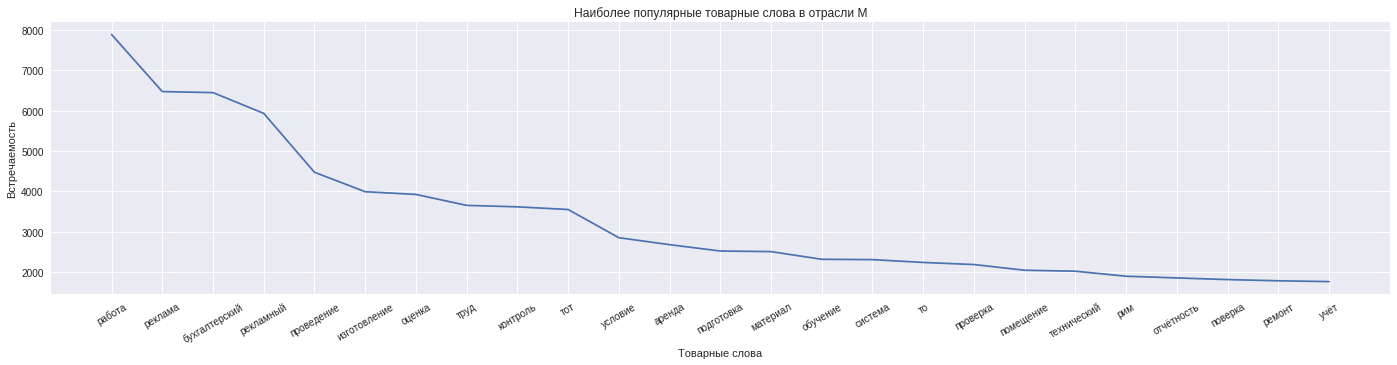

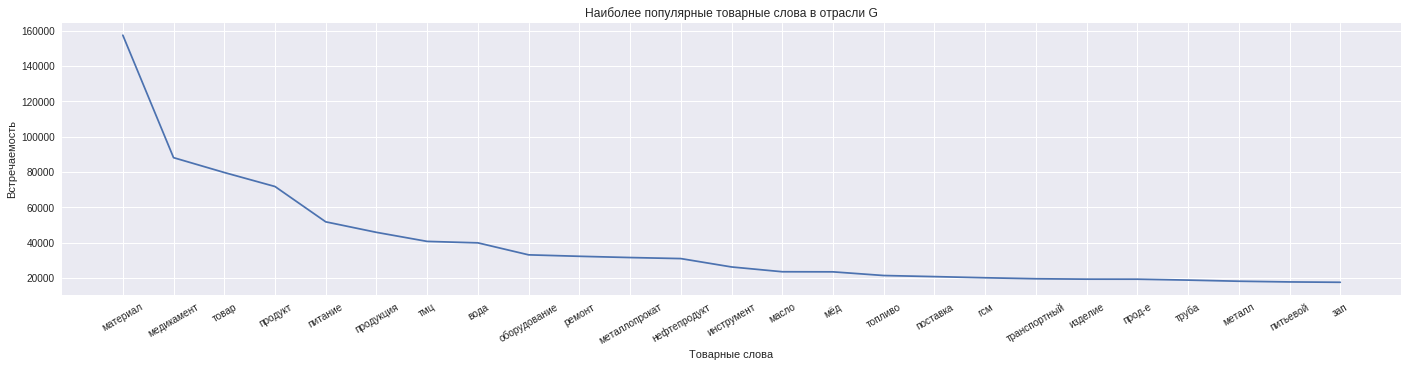

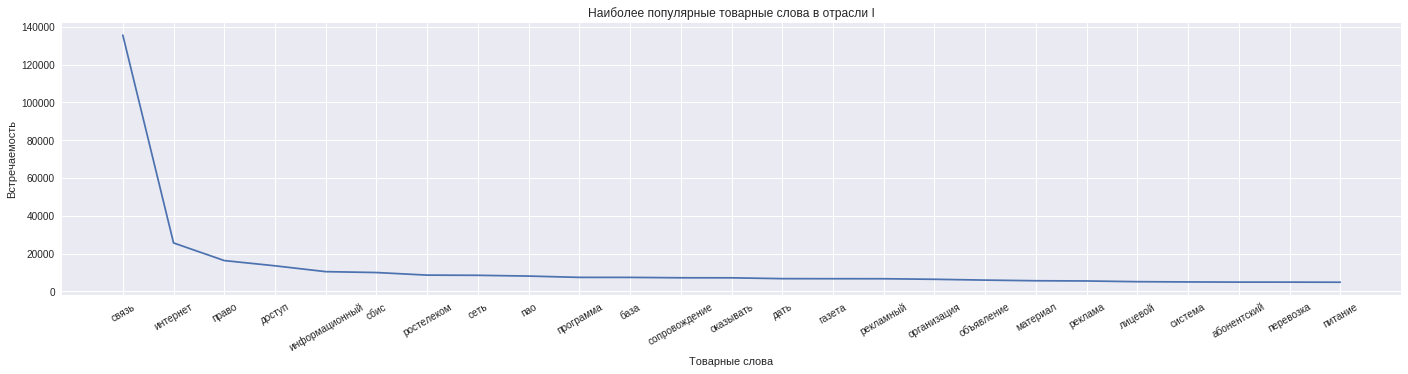

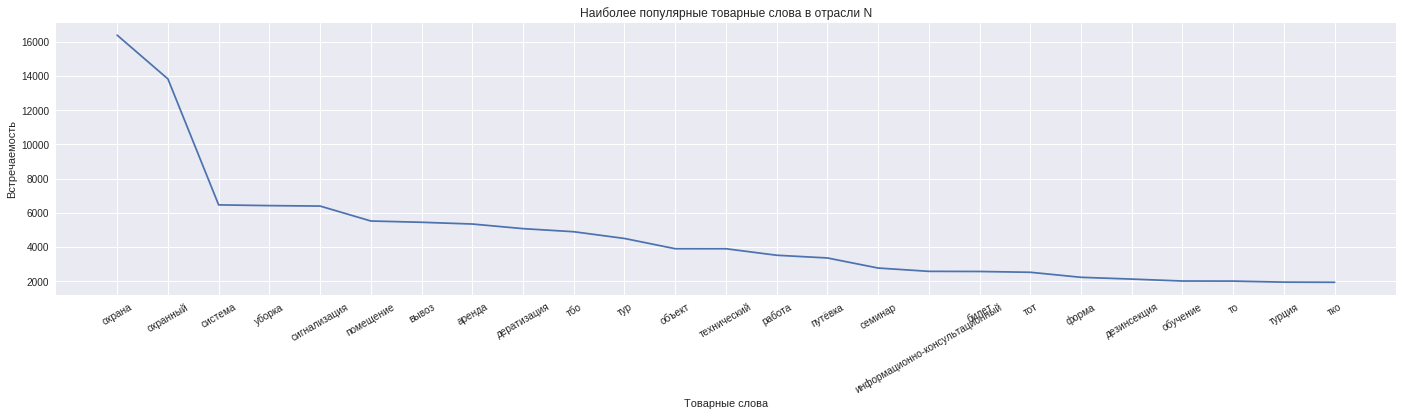

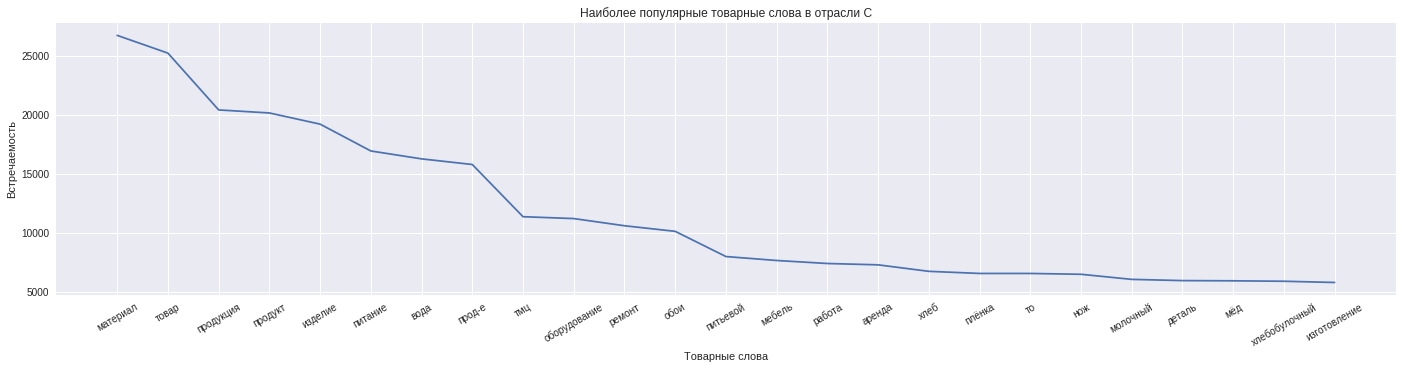

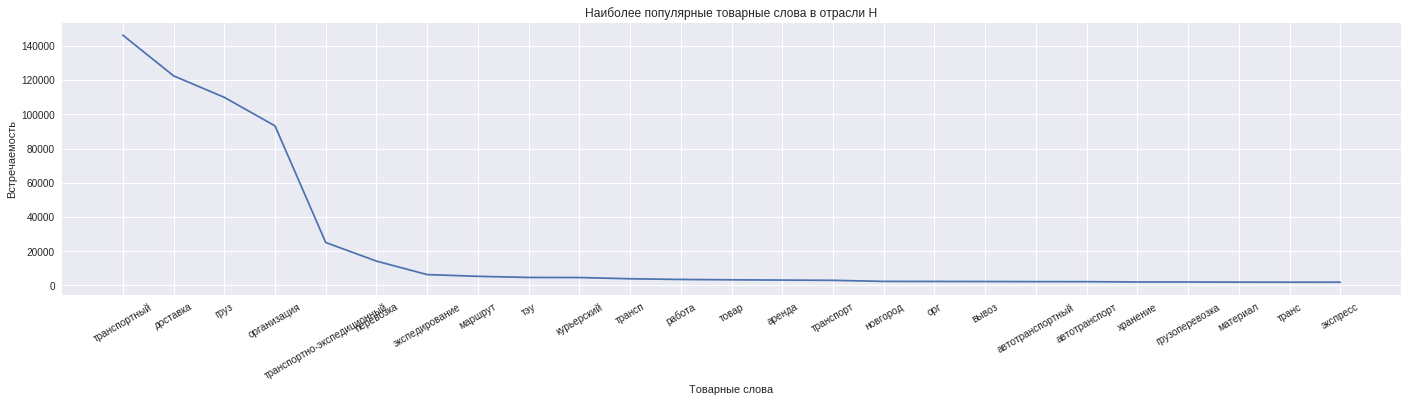

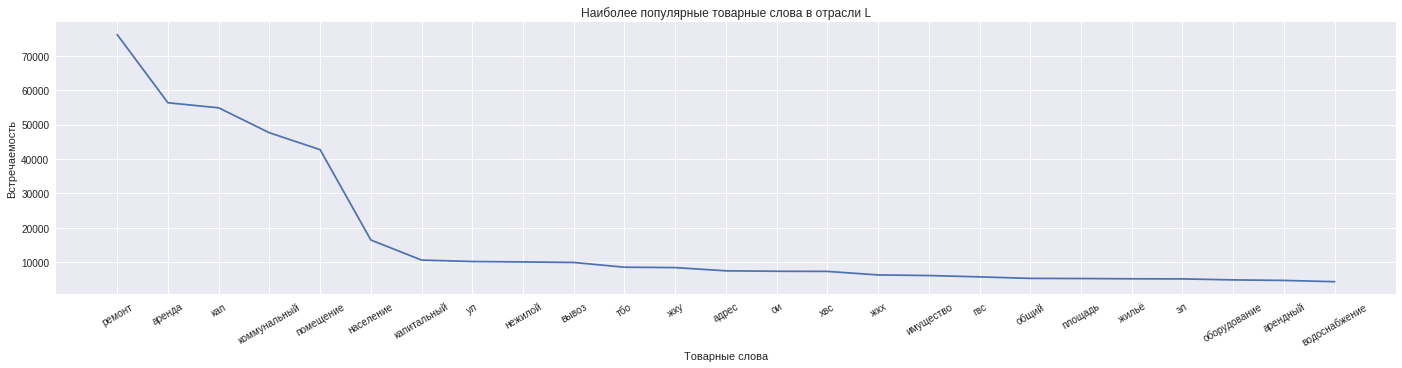

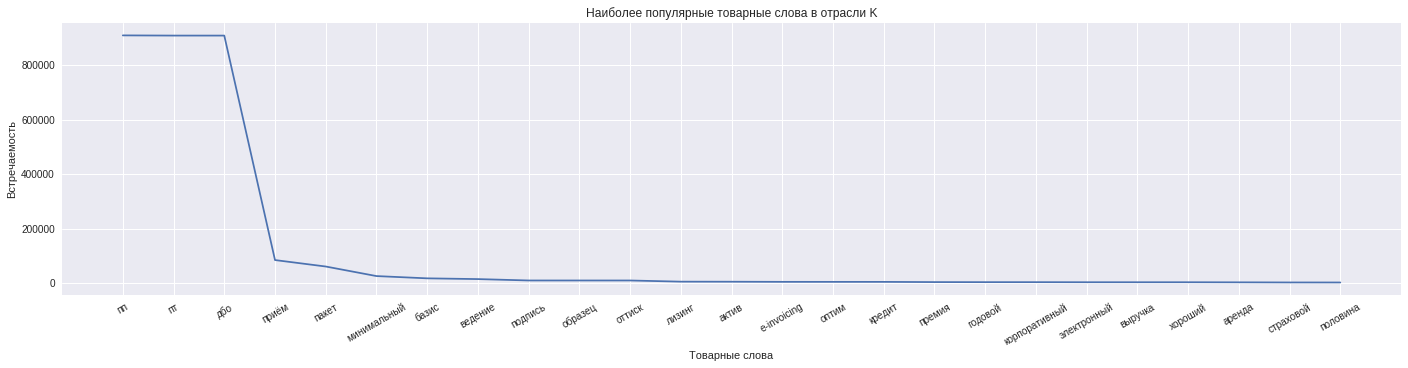

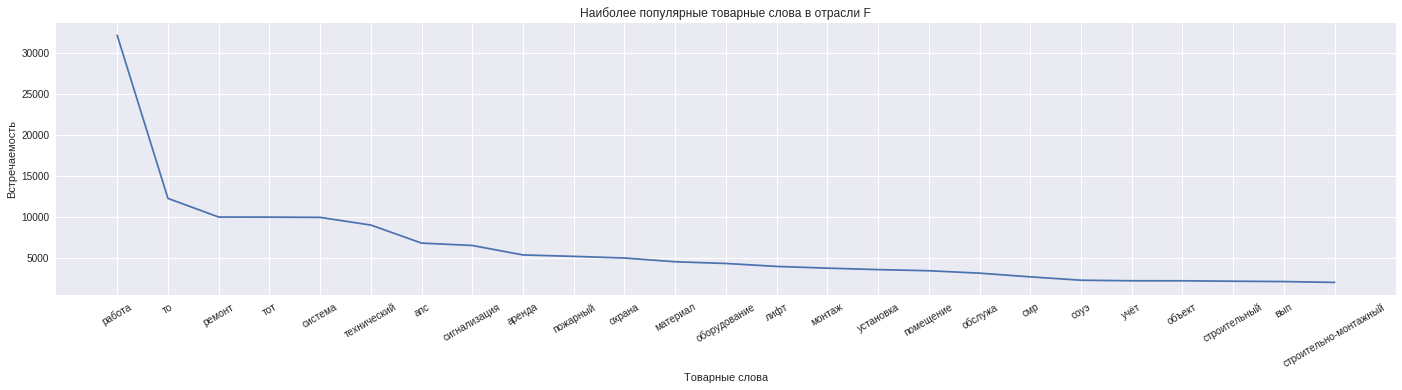

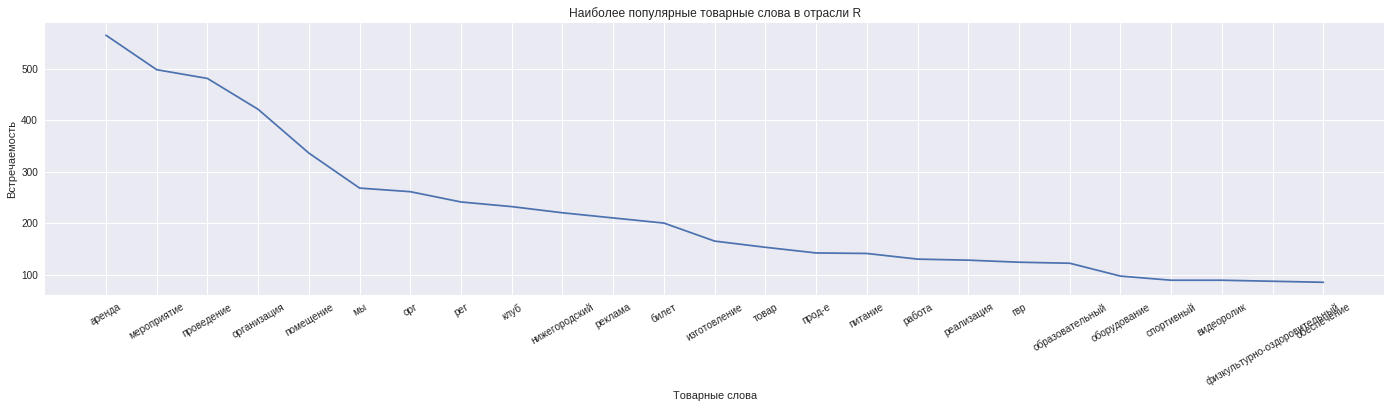

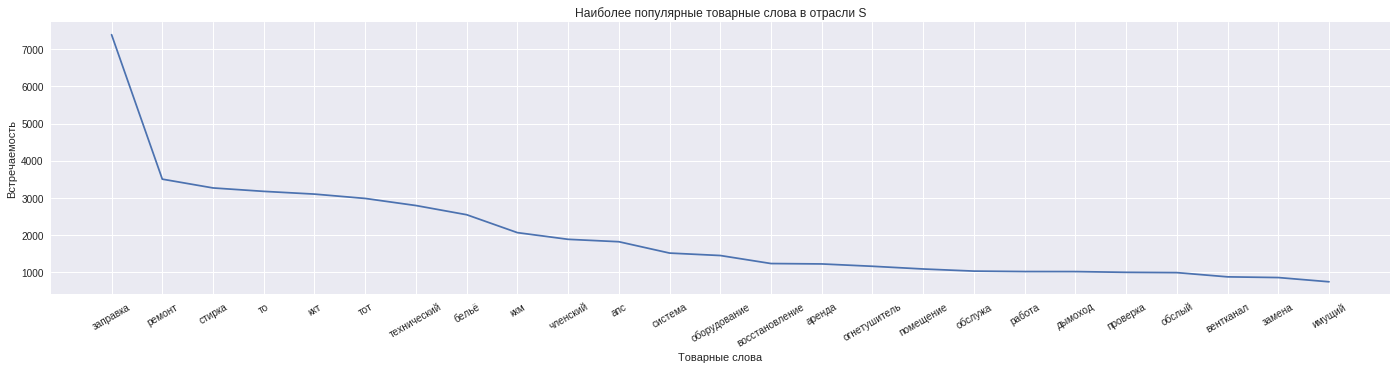

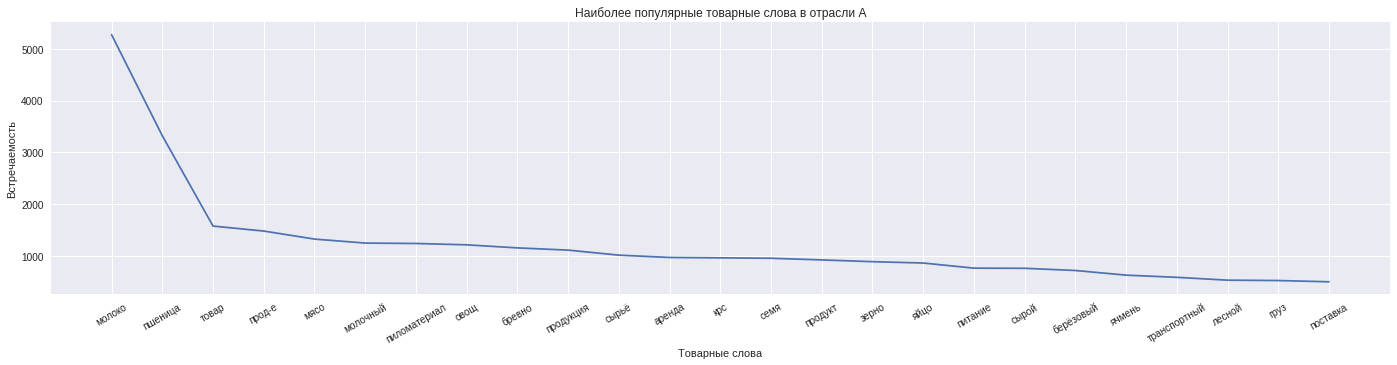

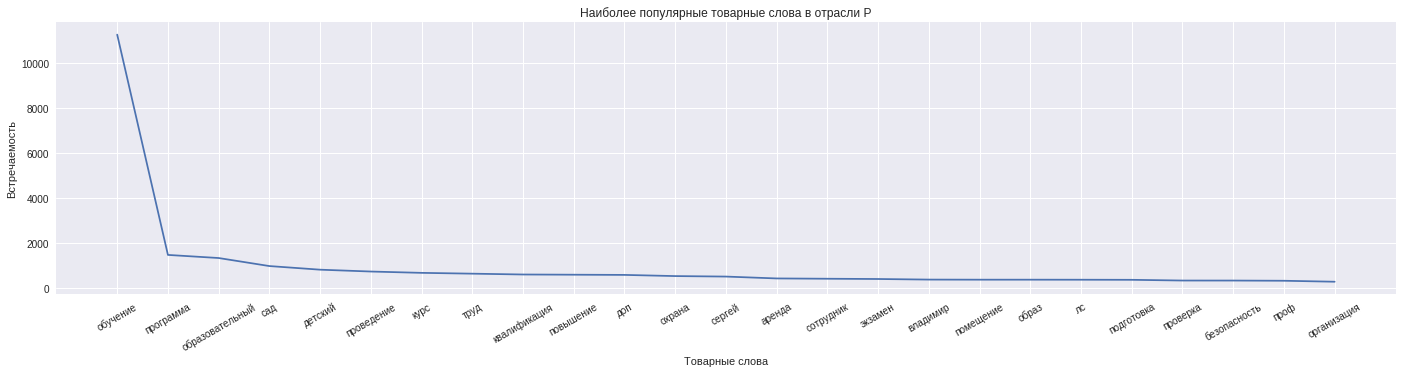

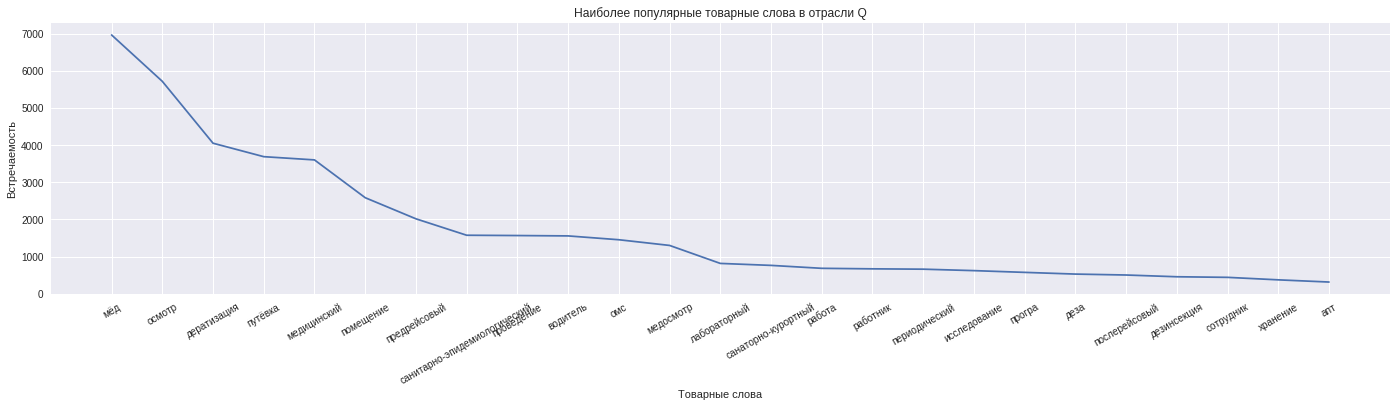

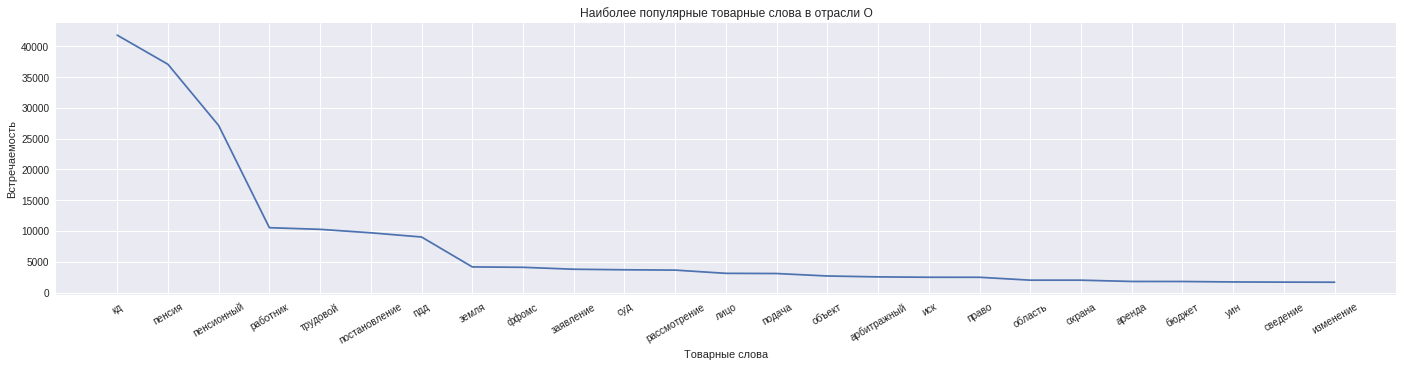

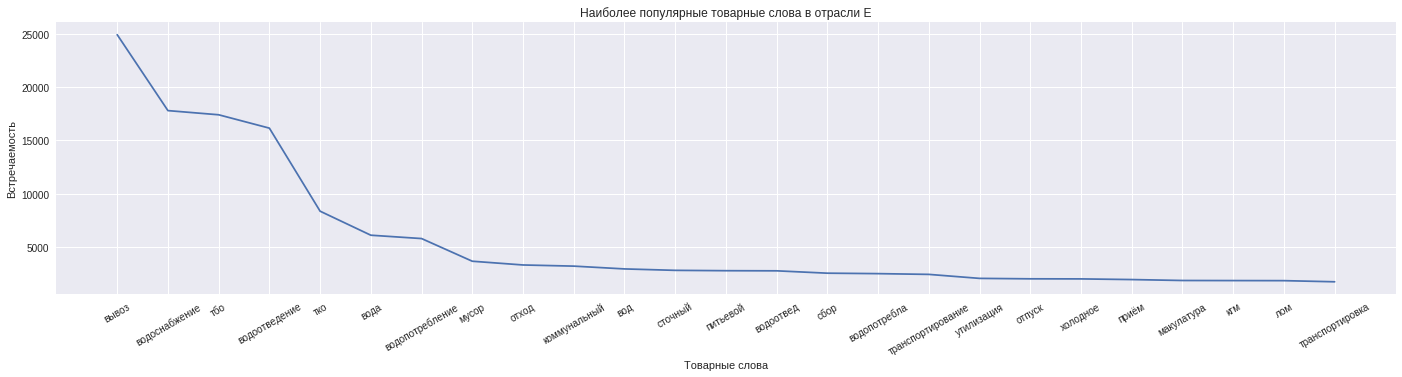

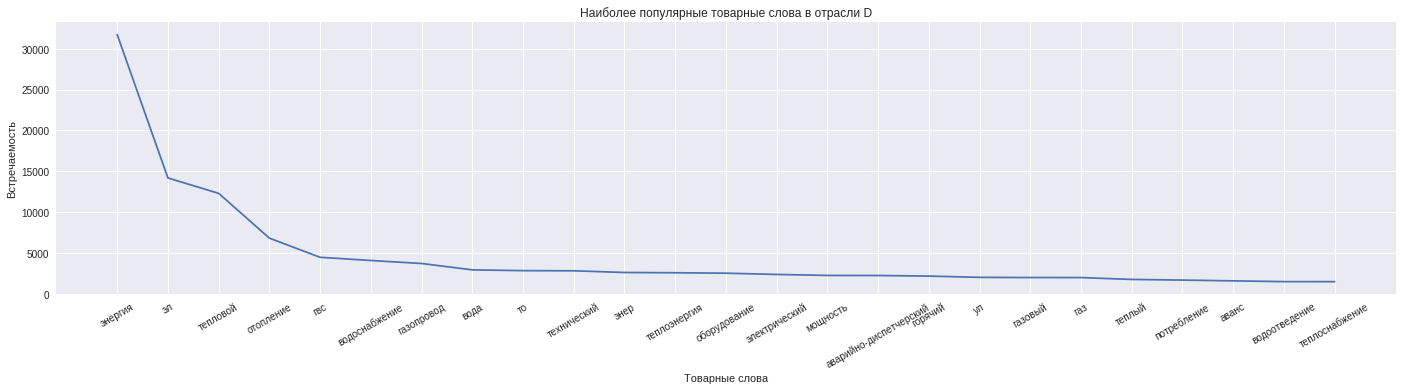

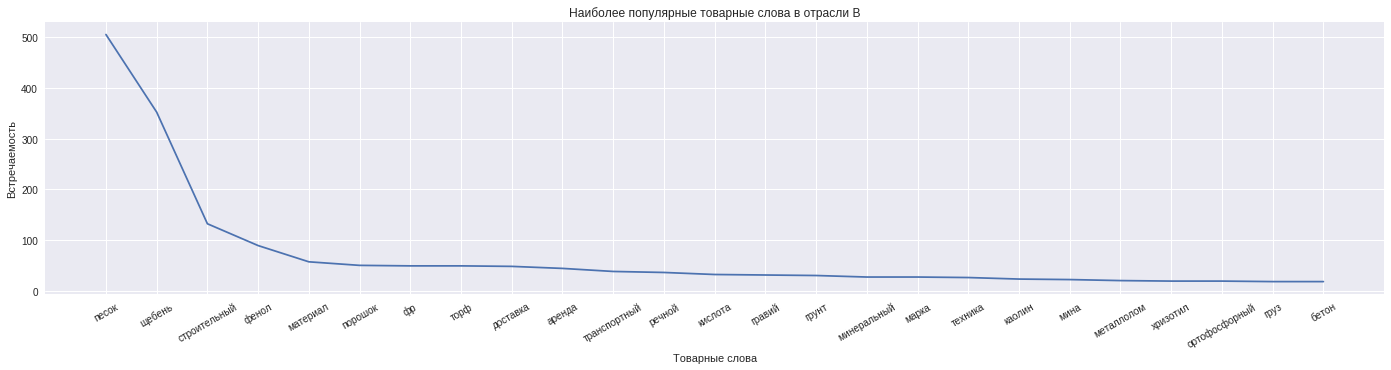

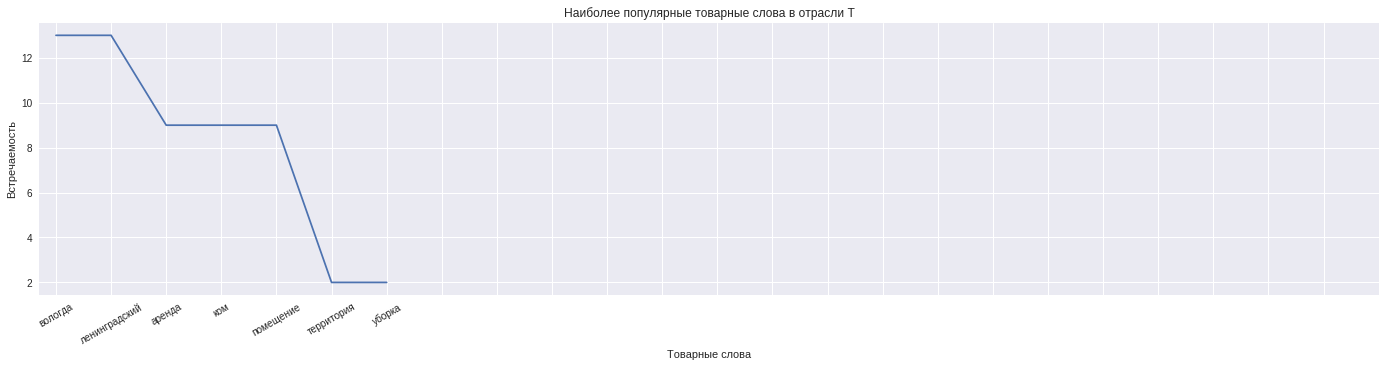

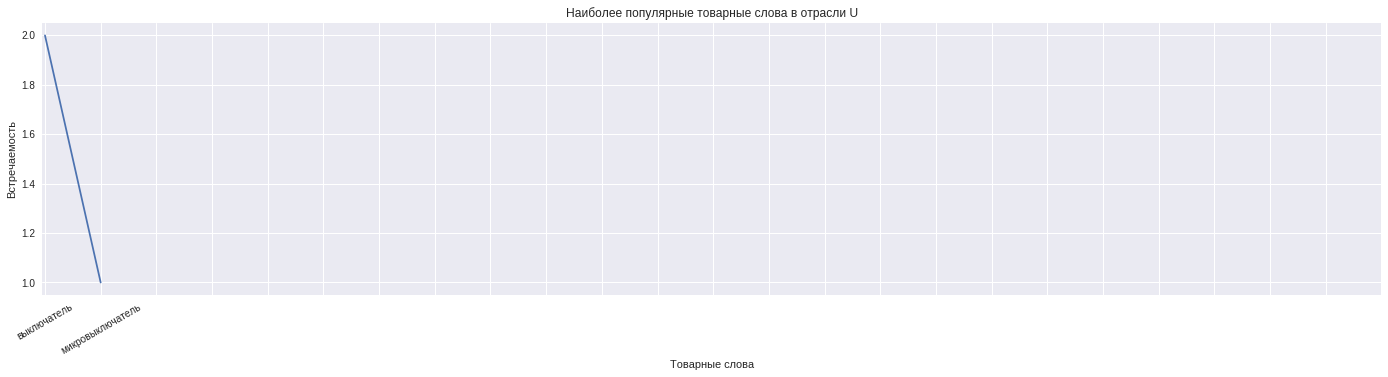

In [45]:
for field in fields:
    plot_words(field, k=25, save=True)

/opt/cloudera/parcels/PYENV.ZNO0059623792/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


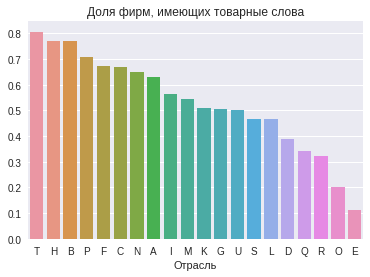

In [77]:
tmp1 = data.loc[data.has_products, 'okved0'].dropna()
tmp2 = data.loc[~data.has_products, 'okved0'].dropna()

vc1 = tmp1.value_counts()
vc2 = tmp2.value_counts()

y = (vc1 / (vc1 + vc2)).sort_values(ascending=False)
sns.barplot(y.index, y)
plt.title('Доля фирм, имеющих товарные слова')
plt.xlabel('Отрасль')
plt.ylabel('')
plt.show()

plt.savefig('./firms_ratio.png')

/opt/cloudera/parcels/PYENV.ZNO0059623792/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


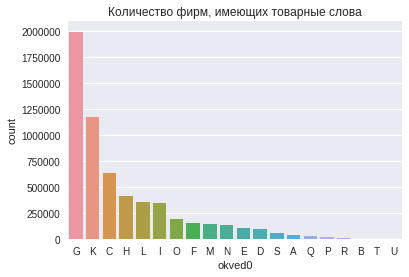

In [78]:
sns.countplot(tmp1, order=tmp1.value_counts().index)
plt.title('Количество фирм, имеющих товарные слова')

plt.savefig('./firms_amount.png')